In [15]:
!pip install transformers==4.22.1

     |████████████████████████████████| 4.9 MB 5.3 MB/s eta 0:00:01
     |████████████████████████████████| 6.6 MB 55.2 MB/s eta 0:00:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.13.2
    Uninstalling tokenizers-0.13.2:
      Successfully uninstalled tokenizers-0.13.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.25.1
    Uninstalling transformers-4.25.1:
      Successfully uninstalled transformers-4.25.1


In [21]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from transformers import logging
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler, DDIMScheduler,  EulerDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image
from matplotlib import pyplot as plt
import numpy
from torchvision import transforms as tfms

# For video display:
from IPython.display import HTML
from base64 import b64encode

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
torch_device

'cuda'

# Init models

In [31]:
path_to_checkpoint = 'CompVis/stable-diffusion-v1-4'
# path_to_checkpoint = 'hakurei/waifu-diffusion'

# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained(path_to_checkpoint, subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text. 
# tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
# text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

#@title Set up the Tokenizer and the Text Encoder
tokenizer = CLIPTokenizer.from_pretrained(
    path_to_checkpoint,
    subfolder="tokenizer",
)
text_encoder = CLIPTextModel.from_pretrained(
    path_to_checkpoint, subfolder="text_encoder"#, torch_dtype=torch.float16
)

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained(path_to_checkpoint, subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

In [4]:
from IPython.display import Markdown
from huggingface_hub import hf_hub_download
import os
#@title Load your concept here
#@markdown Enter the `repo_id` for a concept you like (you can find pre-learned concepts in the public [SD Concepts Library](https://huggingface.co/sd-concepts-library))
repo_id_embeds = "sd-concepts-library/arcane-face" #@param {type:"string"}

#@markdown (Optional) in case you have a `learned_embeds.bin` file and not a `repo_id`, add the path to `learned_embeds.bin` to the `embeds_url` variable 
embeds_url = "" #Add the URL or path to a learned_embeds.bin file in case you have one
placeholder_token_string = "" #Add what is the token string in case you are uploading your own embed

downloaded_embedding_folder = "./downloaded_embedding"
if not os.path.exists(downloaded_embedding_folder):
    os.mkdir(downloaded_embedding_folder)
if(not embeds_url):
    embeds_path = hf_hub_download(repo_id=repo_id_embeds, filename="learned_embeds.bin")
    token_path = hf_hub_download(repo_id=repo_id_embeds, filename="token_identifier.txt")
    !cp $embeds_path $downloaded_embedding_folder
    !cp $token_path $downloaded_embedding_folder
    with open(f'{downloaded_embedding_folder}/token_identifier.txt', 'r') as file:
        placeholder_token_string = file.read()
else:
    !wget -q -O $downloaded_embedding_folder/learned_embeds.bin $embeds_url

learned_embeds_path = f"{downloaded_embedding_folder}/learned_embeds.bin"

display (Markdown("## The placeholder token for your concept is `%s`"%(placeholder_token_string)))

## The placeholder token for your concept is `<arcane-face>`

In [5]:
#@title Load the newly learned embeddings into CLIP
def load_learned_embed_in_clip(learned_embeds_path, text_encoder, tokenizer, token=None):
    loaded_learned_embeds = torch.load(learned_embeds_path, map_location="cpu")

    # separate token and the embeds
    trained_token = list(loaded_learned_embeds.keys())[0]
    embeds = loaded_learned_embeds[trained_token]

    # cast to dtype of text_encoder
    dtype = text_encoder.get_input_embeddings().weight.dtype
    embeds.to(dtype)

    # add the token in tokenizer
    token = token if token is not None else trained_token
    num_added_tokens = tokenizer.add_tokens(token)
    if num_added_tokens == 0:
        raise ValueError(f"The tokenizer already contains the token {token}. Please pass a different `token` that is not already in the tokenizer.")
  
  # resize the token embeddings
    text_encoder.resize_token_embeddings(len(tokenizer))

    # get the id for the token and assign the embeds
    token_id = tokenizer.convert_tokens_to_ids(token)
    text_encoder.get_input_embeddings().weight.data[token_id] = embeds
    

load_learned_embed_in_clip(learned_embeds_path, text_encoder, tokenizer)

# Diffusion loop

In [32]:
import numpy as np

def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        t_img = tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1
        if t_img.shape[1] == 4:
            t_img = t_img[:, :3]
        latent = vae.encode(t_img) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [33]:
uncond_input.attention_mask

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])

0it [00:00, ?it/s]

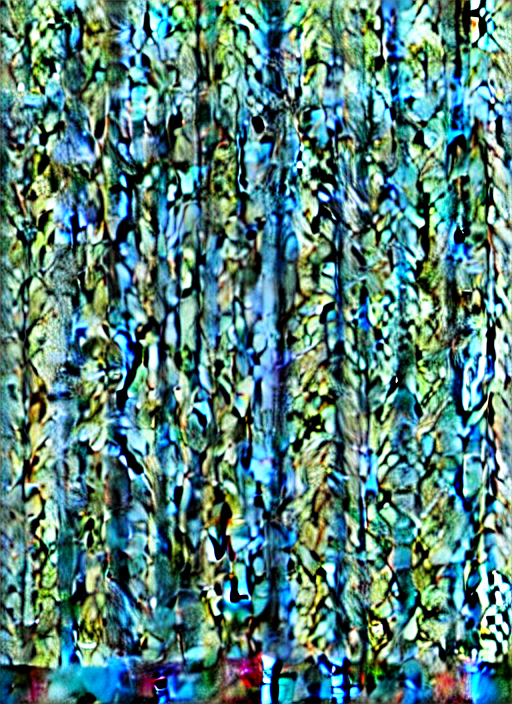

In [36]:
# Settings (same as before except for the new prompt)
prompt = ["original, 1girl, solo, simple background, backlighting, rain, night, depth of field"]
neg_prompt = [""]
height = 704                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 28            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
generator = torch.manual_seed(42)   # Seed generator to create the inital latent noise
batch_size = 1
start_step = 0


# Prep text (same as before)
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device), attention_mask=text_input.attention_mask.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]

uncond_input = tokenizer(
    neg_prompt * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
    
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device), attention_mask=uncond_input.attention_mask.to(torch_device))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler (setting the number of inference steps)
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
    if i >= start_step: # << This is the only modification to the loop we do
        
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        # sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

latents_to_pil(latents)[0]